In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load_data import load_gzip_txt_data

european_countries = [
    "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus",
    "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus",
    "Czech Republic", "Denmark", "England", "Estonia", "Finland", "France", "Georgia",
    "Germany", "Gibraltar", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Jersey", "Kazakhstan",
    "Kosovo", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta",
    "Moldova", "Monaco", "Montenegro", "Netherlands", "Northern Ireland", "Macedonia",
    "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Scotland", "Serbia",
    "Slovakia", "Slovak Republic", "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey",
    "Ukraine", "Vatican City", "Wales"
]

# /!\ Slovakia in RateBeer and Slovak Republic in BeerAdvocate /!\

def get_na_or_eu(row):
    """
    In a Dataframe with a column "location", returns whether the location 
    is in Europe or North America.
    
    :param row: pandas.Dataframe row with an attribute "location".
    :return: str, can be "NA", "EU" or "Other".
    """
    location = row['location']
    if location in european_countries:
        return 'EU'
    elif (location == 'Canada') or ("United States" in str(location)):
        return 'NA'
    else:
        return 'Other'


ba_users_df = pd.read_csv("./data/BeerAdvocate/users.csv")[['user_id', 'location']].dropna()
ba_users_df['eu_na'] = ba_users_df.apply(get_na_or_eu, axis=1)

rb_users_df = pd.read_csv("./data/RateBeer/users.csv")[['user_id', 'location']].dropna()
rb_users_df['eu_na'] = rb_users_df.apply(get_na_or_eu, axis=1)

ba_users_df = ba_users_df.query("eu_na != 'Other'")
rb_users_df = rb_users_df.query("eu_na != 'Other'")

ba_ratings_df = load_gzip_txt_data("./data/BeerAdvocate/ratings.txt.gz",
                                   ["user_id", "date", "abv", "style", "rating", "appearance", "aroma", "palate",
                                    "taste", "overall"])
rb_ratings_df = load_gzip_txt_data("./data/RateBeer/ratings.txt.gz",
                                   ["user_id", "date", "abv", "style", "rating", "appearance", "aroma", "palate",
                                    "taste", "overall"])


Loading data from:  ./data/BeerAdvocate/ratings.txt.gz


151074576it [04:34, 550273.78it/s]


Loading data from:  ./data/RateBeer/ratings.txt.gz


121075258it [03:41, 547798.27it/s] 


In [2]:
ba_ratings_df = ba_ratings_df.astype({
    'user_id': 'str',
    'date': 'int64',
    'abv': 'float32',
    'rating': 'float32',
    'appearance': 'float32',
    'aroma': 'float32',
    'palate': 'float32',
    'taste': 'float32',
    'overall': 'float32'})

rb_ratings_df = rb_ratings_df.astype({
    'user_id': 'int64',
    'date': 'int64',
    'abv': 'float32',
    'rating': 'float32',
    'appearance': 'float32',
    'aroma': 'float32',
    'palate': 'float32',
    'taste': 'float32',
    'overall': 'float32'})

# Convert the dates to monthly periods (useful for plotting):
ba_ratings_df['date'] = pd.to_datetime(ba_ratings_df['date'], unit='s').dt.to_period('m').astype('datetime64[M]')
rb_ratings_df['date'] = pd.to_datetime(rb_ratings_df['date'], unit='s').dt.to_period('m').astype('datetime64[M]')

beer_styles_matching = pd.read_csv("./data/additional/styles_matching.csv", index_col='specific')['general'].to_dict()

def specific_style_to_general(row):
    return beer_styles_matching[row['style']]

ba_ratings_df['style'] = ba_ratings_df.apply(specific_style_to_general, axis=1)
rb_ratings_df['style'] = rb_ratings_df.apply(specific_style_to_general, axis=1)

# Drop Saké
ba_ratings_df = ba_ratings_df.query("style != 'Saké'")
rb_ratings_df = rb_ratings_df.query("style != 'Saké'")

ba_df = ba_ratings_df.merge(ba_users_df, on='user_id').drop(columns=['user_id'])
rb_df = rb_ratings_df.merge(rb_users_df, on='user_id').drop(columns=['user_id'])

del ba_ratings_df
del ba_users_df
del rb_ratings_df
del rb_users_df

ba_style_abv_df = pd.read_csv("./data/BeerAdvocate/beers.csv")[['style', 'abv']].dropna()
rb_style_abv_df = pd.read_csv("./data/RateBeer/beers.csv")[['style', 'abv']].dropna()

ba_style_abv_df = pd.read_csv("./data/BeerAdvocate/beers.csv")[['style', 'abv']].dropna()
rb_style_abv_df = pd.read_csv("./data/RateBeer/beers.csv")[['style', 'abv']].dropna()

ba_style_abv_df['style'] = ba_style_abv_df.apply(specific_style_to_general, axis=1)
rb_style_abv_df['style'] = rb_style_abv_df.apply(specific_style_to_general, axis=1)

# Drop Saké
ba_style_abv_df = ba_style_abv_df.query("style != 'Saké'")
rb_style_abv_df = rb_style_abv_df.query("style != 'Saké'")

sns.set_theme()
hue_order = ['NA', 'EU']
hue_order_styles = rb_df["style"].unique()

In [126]:
# merging ba and rb for time series, since we only need to consider abv

merge_list = ['date', 'style', 'abv', 'appearance', 'palate', 'eu_na']
df_time = pd.concat([rb_df[merge_list], ba_df[merge_list]], ignore_index=True).dropna(subset=['abv'])

df_EU = df_time[df_time['eu_na'] == 'EU']
df_NA = df_time[df_time['eu_na'] == 'NA']

# define a function that groups by the month

def abv_by_month(df):
    """
    Groups the dataframe by month and returns a new dataframe with the average abv for each month with date as index
    We only take time after 2000
    :param df: pandas.Dataframe with a column "date" and a column "abv".
    :return: pandas.Dataframe with a column "date" and a column "abv".
    """
    df = df[(df['date'] > '2003-01-01') & (df['date'] < '2017-01-01')] # NOTE: CONSIDER SPECIFYING DATE RANGE
    df_new = df[['date','abv']].dropna(subset=['abv']).groupby(pd.Grouper(key='date', freq='M')).mean().sort_values(by='date') 
    df_new.index = df_new.index.strftime('%Y-%m')
    df_new.index = pd.to_datetime(df_new.index)
    return df_new


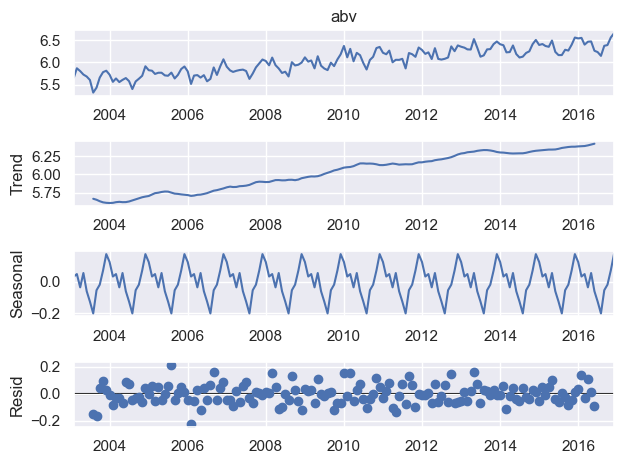

In [127]:
# use time series analysis from stsmodels to find the trend and seasonality
import statsmodels.api as sm

EU_tot = abv_by_month(df_EU)
NA_tot = abv_by_month(df_NA)

res_EU = sm.tsa.seasonal_decompose(EU_tot['abv'])
res_NA = sm.tsa.seasonal_decompose(NA_tot['abv'])

resplot_EU = res_EU.plot()


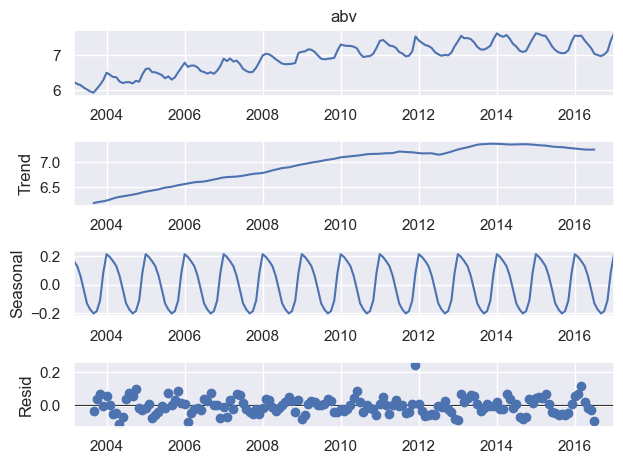

In [122]:
resplot_NA = res_NA.plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


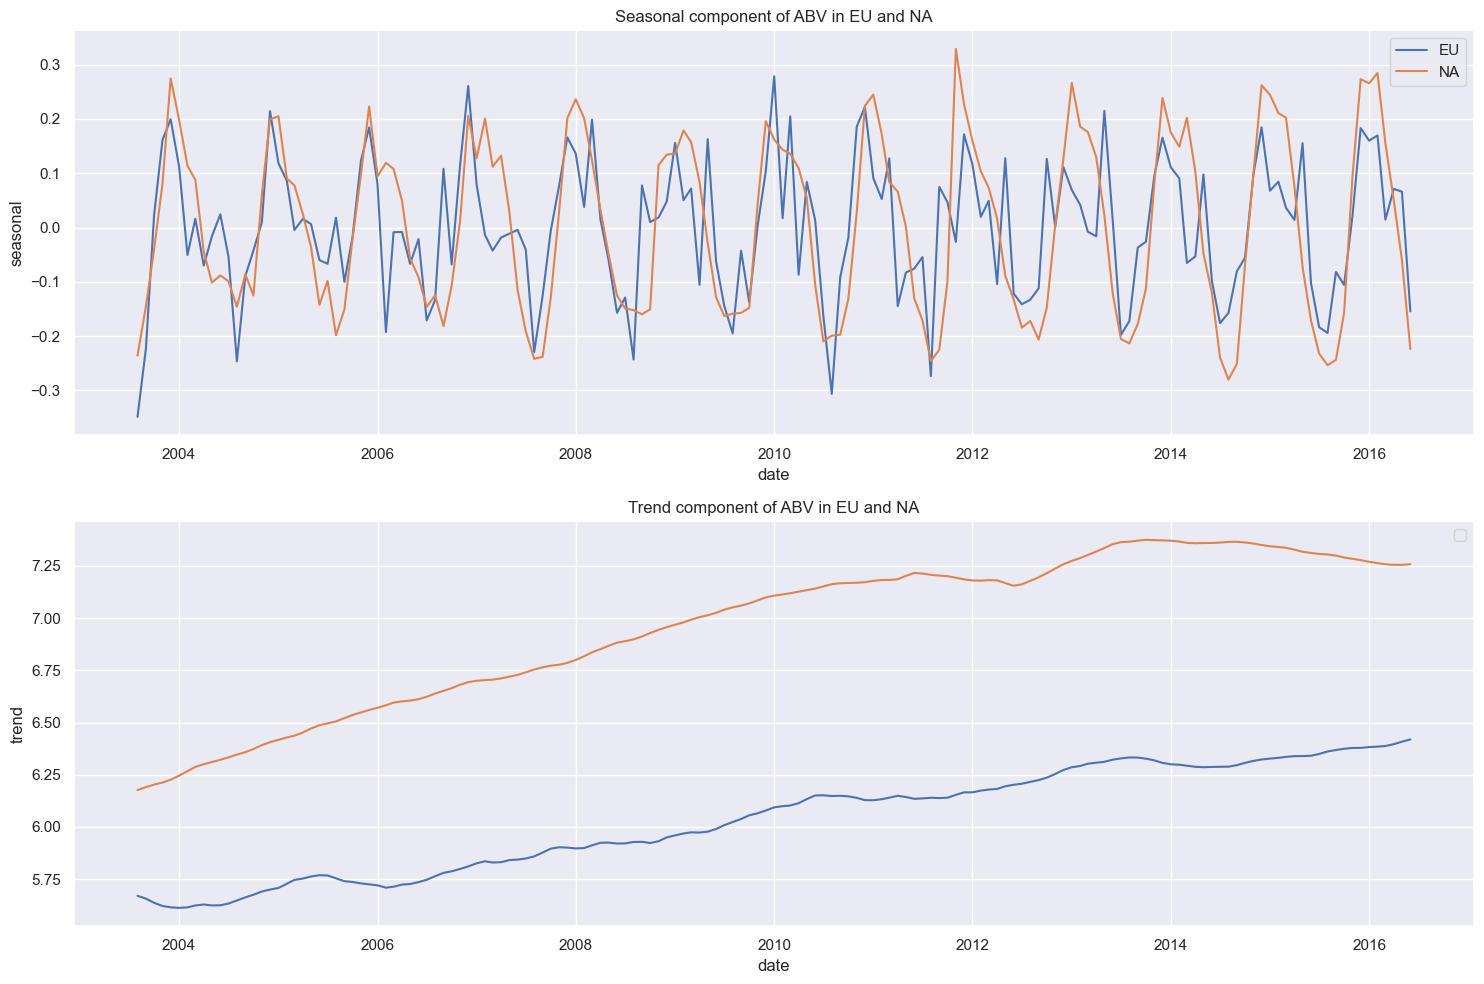

In [443]:
# obtain seasonal component for NA and EU and plot them together as well as trend add all non-trend components for seasonality

# convert res to dataframe

def res_to_df(res):
    """
    Converts the result of seasonal_decompose to a pandas.Dataframe.
    
    :param res: result of seasonal_decompose.
    :return: pandas.Dataframe with columns "observed", "trend", "seasonal", "resid".
    """
    res_df = pd.DataFrame(res.observed)
    res_df['trend'] = res.trend
    res_df['seasonal'] = res.observed - res.trend
    res_df.reset_index(inplace=True)
    return res_df.dropna()

EU_time = res_to_df(res_EU)
NA_time = res_to_df(res_NA)

fig, axes = plt.subplots(2,1, figsize=(15,10))
sns.lineplot(data=EU_time, x='date', y='seasonal', ax=axes[0], label='EU')
sns.lineplot(data=NA_time, x='date', y='seasonal', ax=axes[0], label='NA')
sns.lineplot(data=EU_time, x='date', y='trend', ax=axes[1])
sns.lineplot(data=NA_time, x='date', y='trend', ax=axes[1])
axes[0].set(title='Seasonal component of ABV in EU and NA')
axes[1].set(title='Trend component of ABV in EU and NA')

plt.legend()
plt.tight_layout()
plt.show()

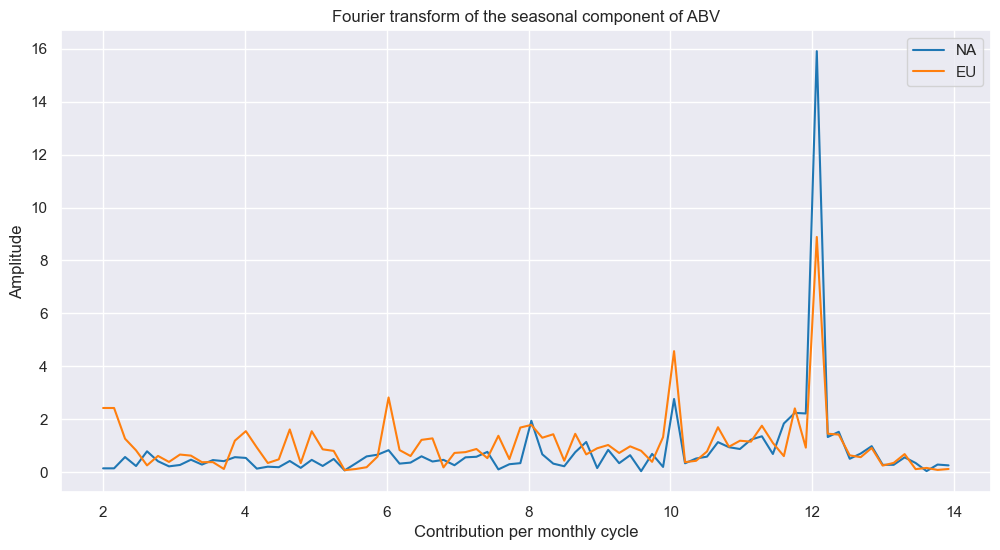

In [444]:
# perform a fourier transform on the seasonal component to find the dominant frequencies
import numpy as np
from scipy.fft import fft, fftfreq, fftshift


def fourier_transform(list_df, names_list):
    """
    Performs a fourier transform on the seasonal component of the dataframe and plots it on a list of df's
    :param list_df: list of pandas.Dataframe with a column "seasonal".
    :param names_list: list of names for the legend
    plot normalised fourier transform of the seasonal component with monthly contributions
    :return: dict with all created ffts
    """
    if len(list_df) > 2:
        palette = sns.color_palette("tab20")
    else:
        palette = sns.color_palette("tab10")
    fft_dict = {}
    fig, ax = plt.subplots(figsize=(12,6))
    for val, df in enumerate(list_df):
        series = df['seasonal']
        N = len(series)
        T = 1 / 12
        yf = np.abs(fft(series.to_numpy()))
        xf = fftfreq(N, T)
        xf = fftshift(xf)
        index = np.where(xf >= 0)
        # convert to monthly contributions, shift by 1 (0 -> 1 because 0 frequency has no meaning here) 
        # and multiply by 2 to account for the negative frequencies
        xf =  (xf[index] + 1) * 2 
        yf =  yf[index]
        yf = yf #/ sum(yf)
        fft_df = pd.DataFrame({'fft': yf, 'time': xf})
        fft_dict[f"df_{names_list[val]}"] = fft_df

        sns.lineplot(data=fft_df, x='time', y='fft', label=names_list[val], color=palette[val], ax=ax)
    ax.set(xlabel='Contribution per monthly cycle', 
            ylabel='Amplitude',
            title='Fourier transform of the seasonal component of ABV')
    if len(list_df) > 2:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return fft_dict

    


# test function

fft_dict = fourier_transform([NA_time, EU_time],['NA', 'EU'])


## Observations
- Main contribution clearly comes from yearly seasonality
- Some shaping coefficients are seen at very 2month interval, as they can be seen in the purely seasonal data as well
- The other contributions are basically noise (residual contribution)

In [445]:
# create abv by month for every style
styles_list = df_EU['style'].unique()
hue_order_styles = styles_list
palette = sns.color_palette("tab20")
df_dict_EU = {} # store all dfs in a dictionary to access them later for the FFT 
df_dict_NA = {}
names_list = []


for style in styles_list:
    # Create your DataFrame (replace this with your actual code to create the DataFrame)
    df1 = df_EU[df_EU['style'] == style]
    df2 = df_NA[df_NA['style'] == style]
    # month averaging
    df1_tot = abv_by_month(df1)
    df2_tot = abv_by_month(df2)
    # seasonal decomposition
    df1_tot = df1_tot.fillna(method='ffill') # fill missing values with previous month to avoid error
    df2_tot = df2_tot.fillna(method='ffill')
    res_df1 = sm.tsa.seasonal_decompose(df1_tot['abv'])
    res_df2 = sm.tsa.seasonal_decompose(df2_tot['abv'])
    # convert to df
    df1_time = res_to_df(res_df1)
    df2_time = res_to_df(res_df2)

    # Store DataFrames in the dictionary
    df_dict_EU[f"df_EU_{style}"] = df1_time
    df_dict_NA[f"df_NA_{style}"] = df2_time

    names_list.append(style)
# extract the dfs from the dictionary and put them in a list
df_list_EU = [df_dict_EU[f"df_EU_{style}"] for style in styles_list]
df_list_NA = [df_dict_NA[f"df_NA_{style}"] for style in styles_list]


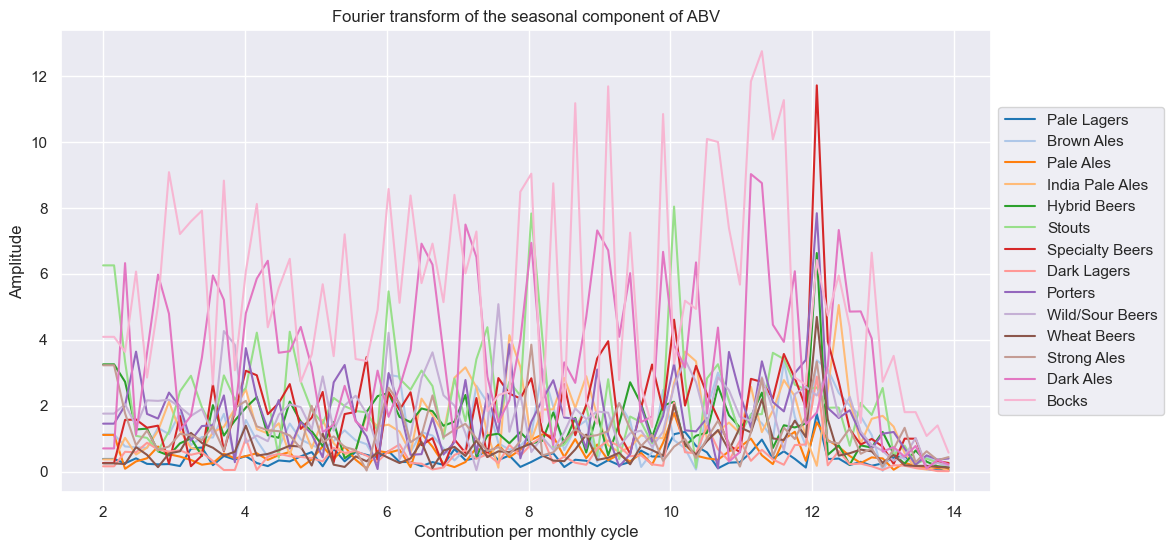

In [446]:
# Now we can finally plot the fourier transform for every style for EU and NA

fft_dict_EU = fourier_transform(df_list_EU, names_list)

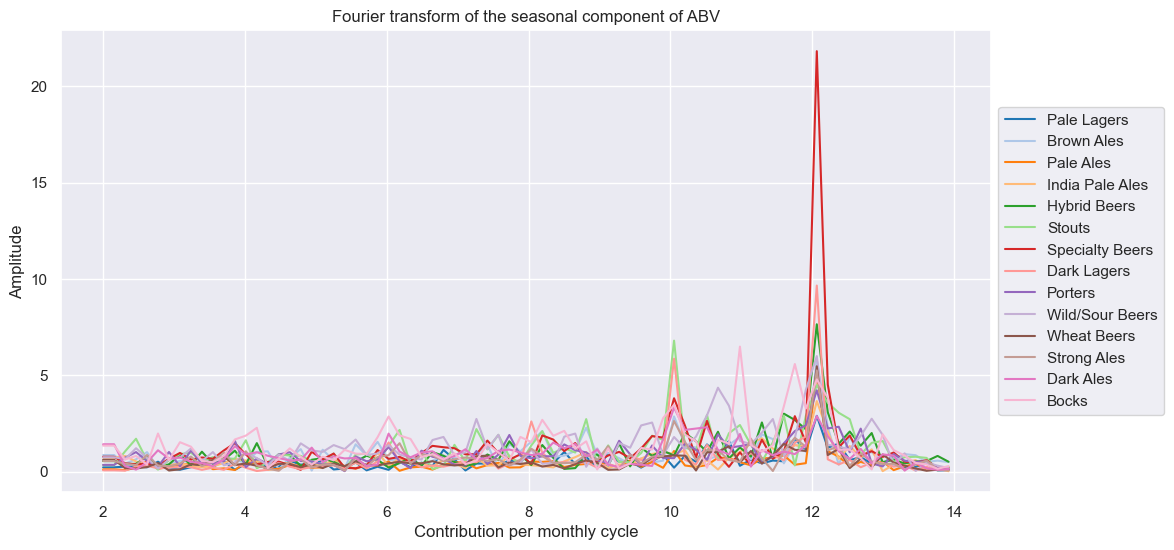

In [447]:
fft_dict_NA = fourier_transform(df_list_NA, names_list)

In [448]:
# filter dicts for styles with max fft value > 0.1

def filter_dict(fft_dict, threshold):
    """
    Filters the dictionary of ffts for styles with a maximum fft value above a threshold.
    
    :param fft_dict: dict with ffts.
    :param threshold: float, threshold for the maximum fft value.
    :return: dict with ffts.
    """
    filtered_dict = {}
    for key, df in fft_dict.items():
        if df['fft'].max() > threshold:
            filtered_dict[key] = df
    return filtered_dict

fft_dict_EU_filtered = filter_dict(fft_dict_EU, 0.05)
fft_dict_NA_filtered = filter_dict(fft_dict_NA, 0.1)

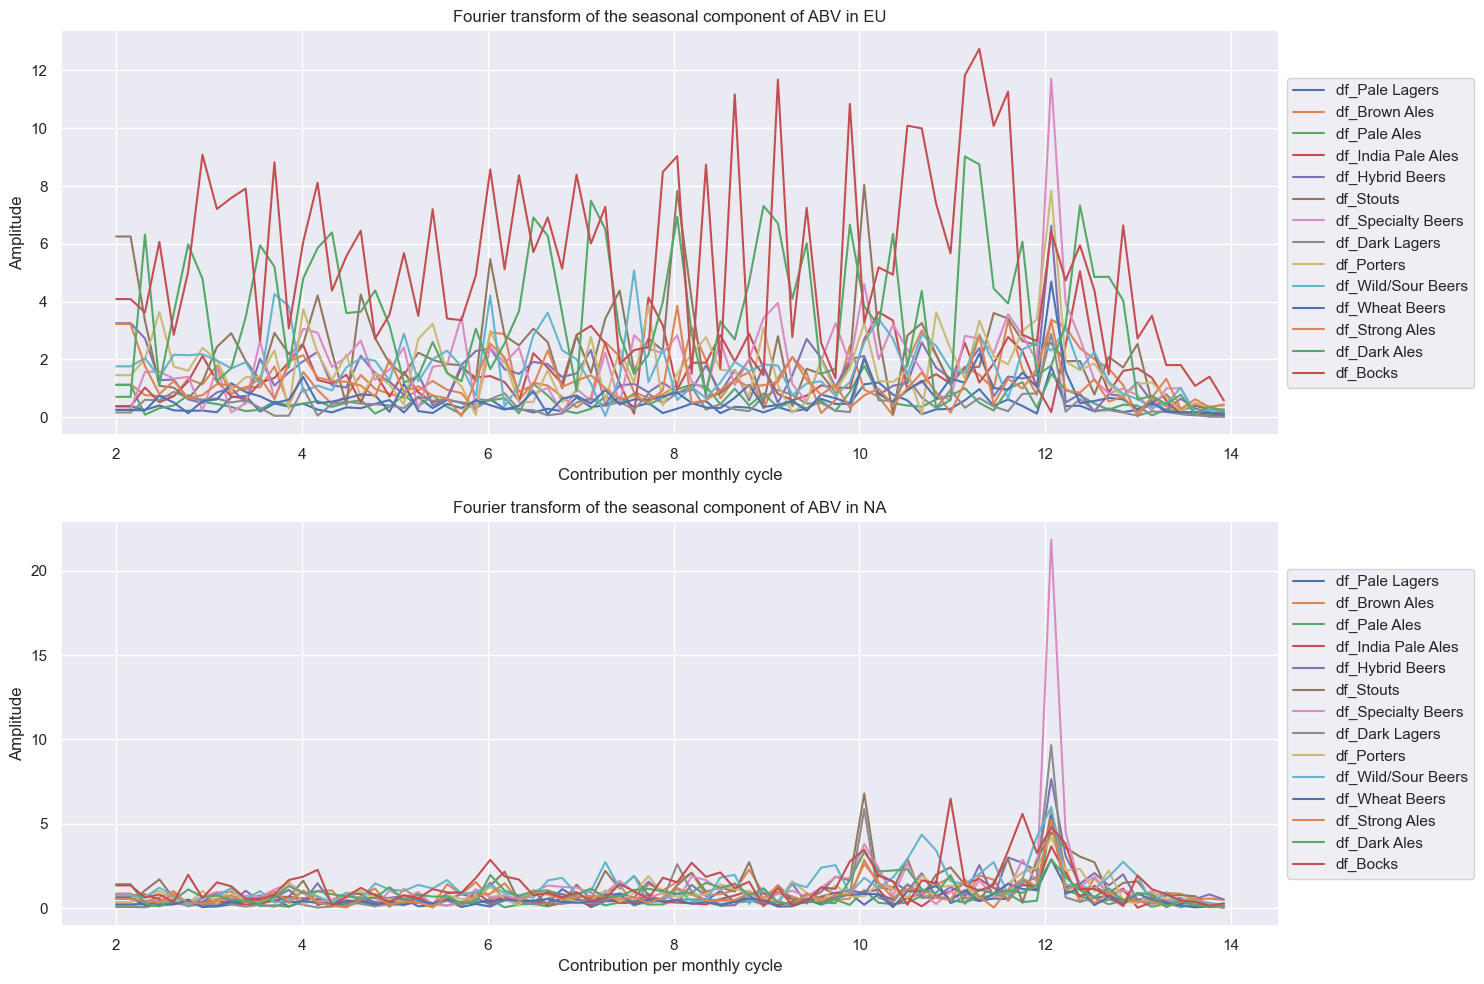

In [449]:
# plot the filtered dicts

fig, axes = plt.subplots(2,1, figsize=(15,10))
for key, df in fft_dict_EU_filtered.items():
    sns.lineplot(data=df, x='time', y='fft', label=key, ax=axes[0])
axes[0].set(xlabel='Contribution per monthly cycle', 
            ylabel='Amplitude',
            title='Fourier transform of the seasonal component of ABV in EU')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for key, df in fft_dict_NA_filtered.items():
    sns.lineplot(data=df, x='time', y='fft', label=key, ax=axes[1])
axes[1].set(xlabel='Contribution per monthly cycle', 
            ylabel='Amplitude',
            title='Fourier transform of the seasonal component of ABV in NA')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [450]:
# create a new dataframe that contains fft_dict['EU'] 'fft' and 'time' as well as all df's stored in df_dict_EU

fft_df_EU = fft_dict['df_EU']
fft_df_EU = fft_df_EU[['time', 'fft']]
fft_df_EU = fft_df_EU.rename(columns={'fft': 'fft_tot'})

# note that we merge closest on time
for key, df in fft_dict_EU.items():
        fft_df_EU = pd.merge_asof(fft_df_EU, fft_dict_EU[key], on='time')
        fft_df_EU = fft_df_EU.rename(columns={'fft': f'{key}'})

# do the same for NA

fft_df_NA = fft_dict['df_NA']
fft_df_NA = fft_df_NA[['time', 'fft']]
fft_df_NA = fft_df_NA.rename(columns={'fft': 'fft_tot'})

# note that we merge closest on time
for key, df in fft_dict_NA.items():
        fft_df_NA = pd.merge_asof(fft_df_NA, fft_dict_NA[key], on='time')
        fft_df_NA = fft_df_NA.rename(columns={'fft': f'{key}'})

# only keep values betweeen 11.5 and 12.5



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


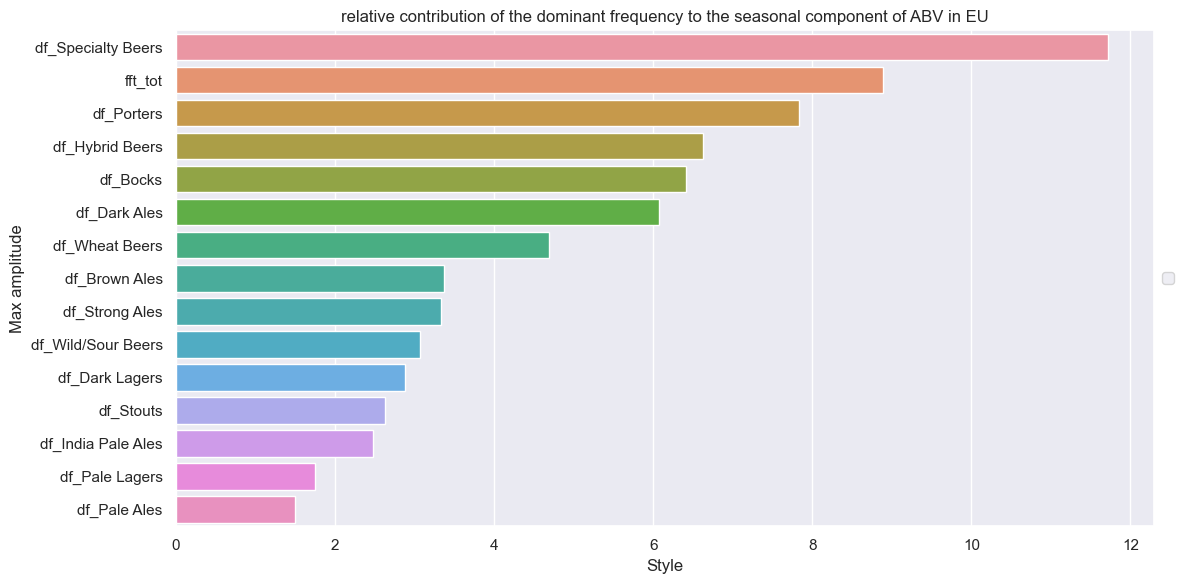

In [454]:
# take max and index of the max of each column and plot them as scatter
fft_df_EU = fft_df_EU[(fft_df_EU['time'] > 11.7) & (fft_df_EU['time'] < 12.3)]
fft_df_NA = fft_df_NA[(fft_df_NA['time'] > 11.7) & (fft_df_NA['time'] < 12.3)]

fft_df_EU.iloc[:, 1:].max()
fft_df_EU.iloc[:, 1:].idxmax()

max_df = pd.DataFrame({'max': fft_df_EU.iloc[:, 1:].max(), 'index': fft_df_EU.iloc[:, 1:].idxmax()})

max_df = max_df[max_df > 0.03]
max_df['max'] = max_df['max']

max_df = max_df.reset_index().rename(columns={'level_0': 'style'}).sort_values(by='max', ascending=False)
# plot the max values as scatter

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=max_df, y='style', x='max')
ax.set(xlabel='Style', ylabel='Max amplitude', 
        title='relative contribution of the dominant frequency to the seasonal component of ABV in EU')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### To DO
- Remove Bocks, they're just noise
- Put a minimum filter for other noise

<AxesSubplot:xlabel='index', ylabel='max'>

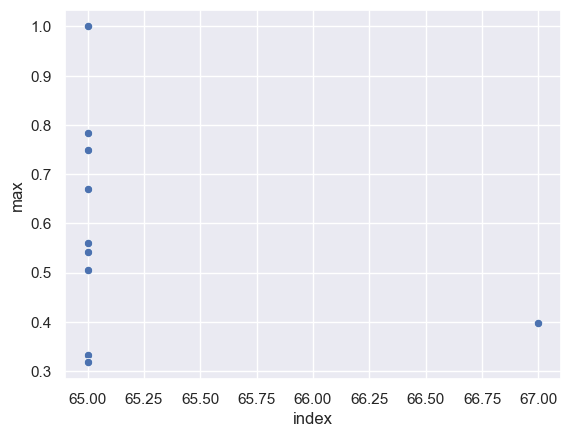

In [437]:
sns.scatterplot(data=max_df, x='index', y='max')